In [82]:
import torch
import numpy as np
import cv2
from PIL import Image, ImageFile
from dataset import Ai4smallDataset
from skimage import io
import imageio
from torch.utils.data import Dataset
from torchvision import transforms
from scipy import io
import os
from glob import glob
from torch.utils.data import DataLoader
import rasterio
import matplotlib.pyplot as plt

In [73]:
class Ai4smallDataset():
    def __init__(self,image_list,flag,dict_format=True):

        self.image_list = image_list
        self.image_ids = [x.split("/")[-1].split(".")[0] for x in self.image_list]
        self.parcel_list= [f"../original/sentinel-2-asia/parcel_mask/{x}.tif" for x in self.image_ids]
        self.mask_list= [f"../original/sentinel-2-asia/{flag}/masks/{x}.tif" for x in self.image_ids]
        self.dict_format=dict_format

    def __getitem__(self, item):

        image_path = self.image_list[item]
        print(image_path)
        #image_path = os.path.join(self.image_path, image_name)
        input_image = self.__open_tiff__(image_path)
        input_image = self.min_max_normalize(input_image)
        input_image = self.resize_array(input_image,(512,512))
        #input_image = image.resize((1024, 1024), Image.ANTIALIAS)
        input_image = torch.tensor(input_image).float()

        parcel_path = self.parcel_list[item]
        parcel_label = self.__open_tiff__(parcel_path)
        parcel_label = self.resize_array(parcel_label,(512,512),mask=True)
        parcel_label = torch.tensor(parcel_label).long()
    
        mask_path = self.mask_list[item]
        #label_path = os.path.join(self.parcel_path, label_name)
        mask_label = self.__open_tiff__(mask_path)
        mask_label = self.resize_array(mask_label,(512,512),mask=True)
        mask_label = torch.tensor(mask_label).long()
        return input_image, parcel_label,mask_label

    def __len__(self):

        return len(self.image_list)
    
    def min_max_normalize(self,image):
        # Assuming image shape is n_channels x height x width
        channel_mins=np.min(image,axis=(1,2,),keepdims=True)
        channel_maxs=np.max(image,axis=(1,2),keepdims=True) 
        normalized_array = (image-channel_mins)/(channel_maxs-channel_mins)
        return normalized_array

    def __open_tiff__(self,image_path):
        image=rasterio.open(image_path).read()
        return image
        
    def resize_array(self,array, new_size,mask=False):
        # Transpose the array to height x width x channels
        array = np.transpose(array, (1, 2, 0))
        if mask:
            array=np.squeeze(array,2)
            

        array = array * 255
        # Convert to PIL Image
        pil_image = Image.fromarray(array.astype(np.uint8))

        # Resize the image
        resized_image = pil_image.resize(new_size)

        # Convert back to numpy array
        resized_array = np.array(resized_image)
        if mask:
            resized_array=np.expand_dims(resized_array,2)

        # Transpose back to channels x height x width
        resized_array = np.transpose(resized_array, (2, 0, 1))
        
        resized_array = resized_array/255

        return resized_array

In [76]:

train_image_list=glob("/home/geospatial/sambal/sam_boundary_adapter/original/sentinel-2-asia/train/images/*")
val_image_list=glob("/home/geospatial/sambal/sam_boundary_adapter/original/sentinel-2-asia/validate/images/*")

train_data=Ai4smallDataset(train_image_list,'train')
train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=False)

val_data=Ai4smallDataset(val_image_list,'validate')
val_dataloader = DataLoader(dataset=val_data, batch_size=1, shuffle=False)


In [77]:
image,parcel,mask=next(iter(train_dataloader))

/home/geospatial/sambal/sam_boundary_adapter/original/sentinel-2-asia/train/images/49_vietnam.tif


In [78]:
image_np=image.squeeze(0)[:3,:,:].permute(1,2,0).numpy()
parcel_np=parcel.squeeze(0).permute(1,2,0).numpy()
mask_np=mask.squeeze(0).permute(1,2,0).numpy()

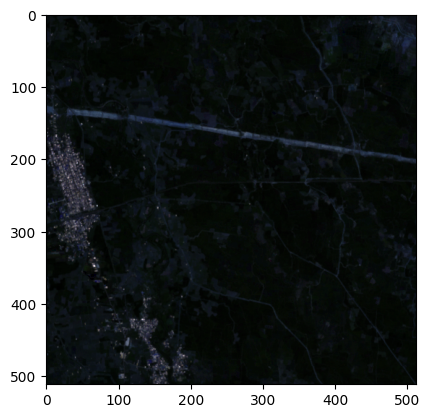

In [79]:
plt.imshow(image_np)
plt.show()

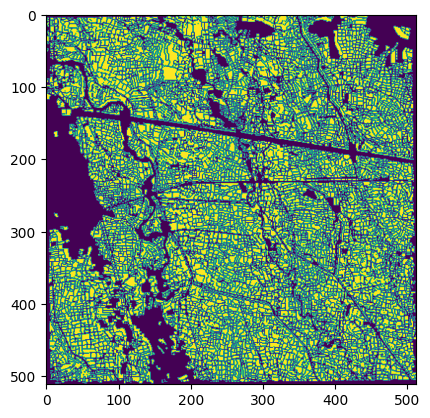

In [80]:
plt.imshow(parcel_np)
plt.show()

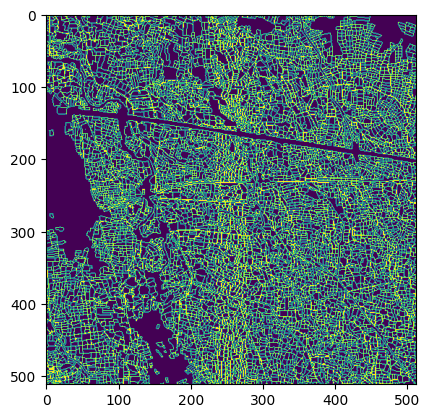

In [81]:
plt.imshow(mask_np)
plt.show()

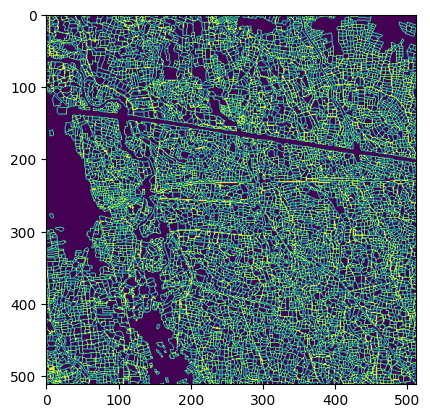

In [67]:
x=rasterio.open("/home/geospatial/sambal/sam_boundary_adapter/original/sentinel-2-asia/train/masks/49_vietnam.tif").read()
plt.imshow(x.transpose(1,2,0))
plt.show()